In [5]:
import kwant 
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, asdict
from kwant.continuum import discretize  
sx = np.array([[0 , 1] , [1 , 0]])
sy = np.array([[0 , -1j] , [1j , 0]])
sz = np.array([[1 , 0] , [0 , -1]])
id = np.array([[1 , 0] , [0 , 1]])
from pfapack import pfaffian as pf

%matplotlib widget

## In this Notebook
- Band structure of Andreev bound states confined to junction.
- Calculation of the topological phase diagram using Kitaev's Pfaffian formula for the fermion parity switch of the 1D system.
- Calculating the bulk band gap at $k_x = 0$ for different values of $\varphi$ and $E_Z$ 
- Taking the 

### Band structure calculation

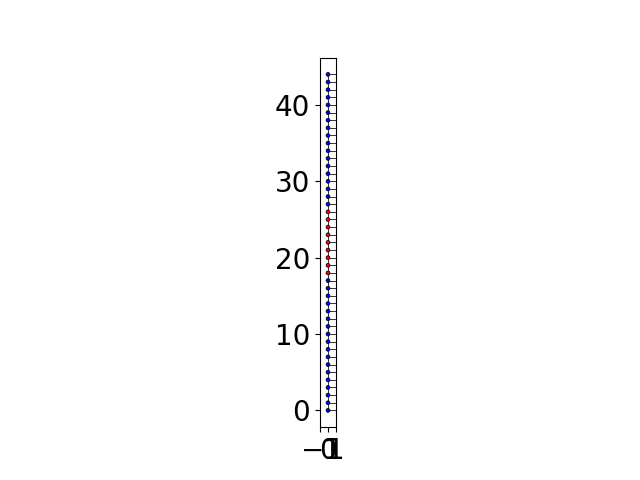

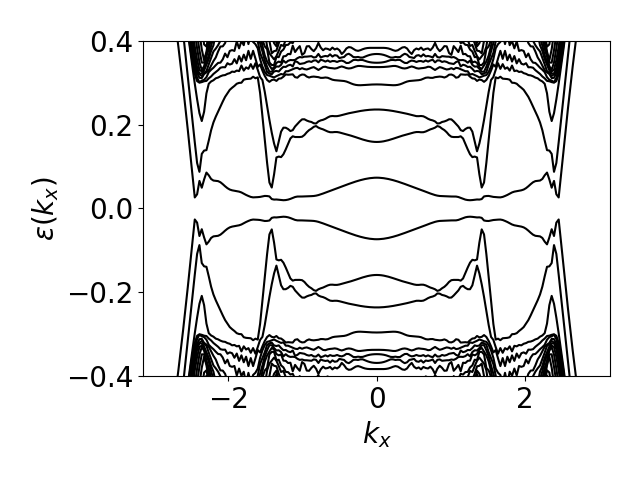

In [225]:
from scipy import constants
from sympy import exp
from josephson_current_tools import constants
@dataclass
class parameters:
    a : float # Lattice constant
    L_x : float # Dimension of planar system in x direction
    L_y : float # Dimension of planar system in y direction
    W : float # Width of the normal region in y direction
    m_eff : float # Effective mass
    mu : float # Chemical potential  
    alpha : float # Rashba coupling
    E_z : float # In plane Zeeman
    Deltabottom : float # Superconducting gap in bottom superconductor.
    Deltatop : float # Superconducting gap in top superconductor.
    phase : float # Phase bias of Josephson junction
    k : float # Boltzmann constant
    T : float # Temperature
    current_unit: float # Current unit

def make_lead(params, plot):
    # Continuum model:
    hamiltonian_bottom = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + Deltabottom*kron(sigma_x , sigma_0)"""

    hamiltonian_top = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + 0.5*Deltatop*exp1*kron(sigma_x + I*sigma_y , sigma_0) + 0.5*Deltatop*exp2*kron(sigma_x - I*sigma_y , sigma_0)"""

    hamiltonian_normal = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) """

    template_sc_top = discretize(hamiltonian_top , locals = {'exp1' : np.exp(1j*params.phase) , 'exp2': np.exp(-1j*params.phase)} ,  grid = params.a )
    template_sc_bottom = discretize(hamiltonian_bottom ,  grid = params.a)
    template_normal = discretize(hamiltonian_normal , grid = params.a)

    lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))

    # Modified shape functions for a translationall invariant lead in the x-direction:
    half_w = params.W // 2
    half_L_y = params.L_y // 2

    def normal_region_color(site):
        if normal_region(site) == True:
            return 'red'
        else: 
            return 'blue'

    def normal_region(site):
        (x , y) = site.pos
        return ((half_L_y - half_w)< y < (half_L_y + half_w))
    
    def bottom_super_region(site):
        (x , y) = site.pos
        return (0 <=y <= (half_L_y - half_w))
    
    def top_super_region(site):
        (x , y) = site.pos
        return ((half_L_y + half_w)  <= y < params.L_y)
    
    lead.fill(template_sc_bottom , bottom_super_region , (0 , 0) )
    lead.fill(template_normal , normal_region , (0 , (half_L_y - half_w) + 1))
    lead.fill(template_sc_top , top_super_region , (0 , (half_L_y + half_w)))

    if plot == True:
        kwant.plot(lead , site_lw = 0.1 ,  site_color = normal_region_color );
    return lead.finalized()

params_ = parameters(a = 1 , L_x = 0, L_y = 45 , W  = 10 , m_eff = 0.5, mu = 2.8 , alpha = 1 , E_z= 0.28 , Deltatop = 0.3 , Deltabottom = 0.32, phase = 0.57*np.pi, k = constants.k , T = 0.05 , current_unit = constants.current_unit)
syst  = make_lead(params_ , plot = True)

# Plotting band structure of the Josephson junction: 
bands = kwant.physics.Bands(syst , params = asdict(params_))
momenta = np.linspace(-np.pi , np.pi , 201)
energies = [bands(k) for k in momenta]
fig , ax = plt.subplots()
ax.plot(momenta , energies , color = 'k');
ax.set_xlim(left = -np.pi , right = np.pi)
ax.set_ylim(bottom = -params_.Deltatop - 0.1 , top = params_.Deltatop + 0.1)
ax.set_xlabel(r'$k_{x}$')
ax.set_ylabel(r'$\epsilon(k_{x})$')
plt.tight_layout()

### Phase diagram calculation:

Testing Pfaffian expression for the $\mathbb{Z}$ invariant:
$$ \mathcal{Q} = \frac{Pf[\mathcal{H}(k = \pi) \sigma_{y}\tau_{y}]}{Pf[\mathcal{H}(k = 0) \sigma_{y}\tau_{y}]} $$


In [226]:
def z_invariant(ham_0 , ham_pi):
    """ Given a bloch Hamiltonians at k = 0 and k = \pi, this function calculates the Z invariant for the wire using the Pfaffian formula for particle-hole symmetric Hamiltonians"""
    # Calculating the number of sites:
    shape = ham_0.shape[0]
    no_sites = shape // 4

    # Constructing particle-hole symmetry operator:
    P = np.kron(sy , sy)

    # Apply particle-hole operator on each site:
    identity = np.identity(no_sites)
    P_allsites = np.kron(identity , P)

    # Calculating pfaffians:
    numerator = pf.pfaffian(ham_pi@P_allsites)
    denominator = pf.pfaffian(ham_0@P_allsites)
    
    # Invariant:
    Q = np.sign(numerator / denominator)

    return Q

def bloch_hamiltonian(band_object , k):
    """
    Calculates the Bloch vector at wave vector k:
    H(k) = H_onsites + V_{hop} exp(-ik) + V_{hop}^{\dagger} exp(ik) 

    which is solved for the bands at k :
    H(k) \Psi = E\Psi

    Inputs:
    band_object : kwant.physis.Bands object for system.
    k: momentum number
    """
    ham_onsite = band_object.ham
    V_hop = band_object.hop

    hopping_matrix = V_hop * (np.cos(k) - 1j*np.sin(k))

    # Bloch Hamiltonian matrix:
    H_k = ham_onsite + hopping_matrix + hopping_matrix.conjugate().transpose()

    return H_k


# Calculating the Bloch hamiltonians:
ham_0 = bloch_hamiltonian(bands , 0)
ham_pi = bloch_hamiltonian(bands , np.pi)

Q = z_invariant(ham_0 , ham_pi)

print(Q)


(-1+0j)


Phase diagram:

In [227]:
phase_values = np.linspace(0 , 2, 41)
zee_values = np.linspace(0 , 2 , 41)

chern_numbers = np.zeros(shape = (len(phase_values) , len(zee_values)))
E_gap = np.zeros(shape = (len(phase_values) , len(zee_values)))
from tqdm import tqdm

for i in tqdm(range(len(phase_values))):
    for j in tqdm(range(len(zee_values))):
        params = parameters(a = 1 , L_x = 0, L_y = 50 , W  = 6 , m_eff = 0.5 , mu = 6 , alpha = 0.5 , E_z= zee_values[j] , Deltatop = 0.3 , Deltabottom = 0.3,  phase = np.pi*phase_values[i], k = constants.k , T = 0.05 , current_unit = constants.current_unit)
        syst  = make_lead(params , plot = False)
        bands = kwant.physics.Bands(syst , params = asdict(params))
        momenta = np.linspace(-np.pi , np.pi , 101)

        energies = [bands(k) for k in momenta]
        energies_abs = np.abs(energies)
        E_gap[i , j] = np.min(energies_abs)

        ham_0 = bloch_hamiltonian(bands , 0)
        ham_pi = bloch_hamiltonian(bands , np.pi)

        chern_numbers[i , j] = z_invariant(ham_0 , ham_pi).real

100%|██████████| 41/41 [21:27<00:00, 31.40s/it]


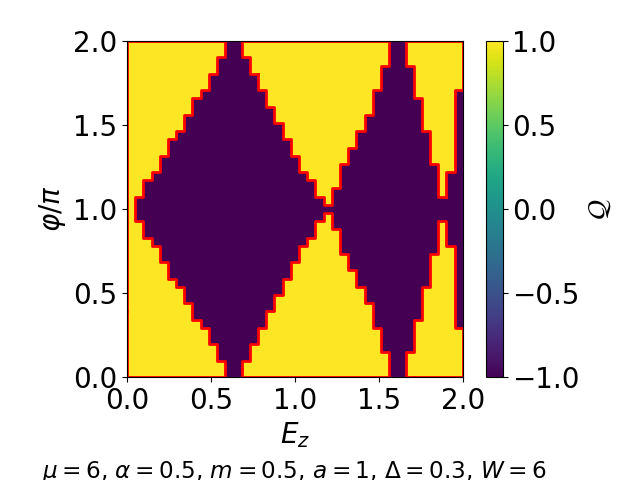

In [230]:
import matplotlib as mpl

mpl.rcParams.update({'font.size': 20})

# E_th:
E_T = 0.5*np.pi*np.sqrt(2*params.mu / params.m_eff)/params.W

fig , ax = plt.subplots()
Z , Phi = np.meshgrid(zee_values , phase_values)

im = ax.imshow(chern_numbers , extent = [np.min(zee_values) , np.max(zee_values) , np.min(phase_values) , np.max(phase_values)])
ax.set_xlabel(r'$E_{z}$')
ax.set_ylabel(r'$\varphi / \pi$')

# parameter string:
title = r'$\mu = $' + str(params.mu) + ', ' + r'$\alpha = $' + str(params.alpha) + ', ' +  r'$m = $' + str(params.m_eff) + r', $a = $' + str(params.a) + r', $\Delta = $' + str(params.Deltabottom) + r', $W = $' + str(params.W)
fig.text(0.46 , 0.005 , title , ha = 'center' , fontsize = 'small')
plt.colorbar(mappable = im , label = r'$\mathcal{Q}$')

# Generating an array of topological phase boundaries:
import shapely.geometry
import shapely.ops

geoms = []

ph = np.linspace(0 , np.max(phase_values) , len(phase_values) + 1)
zee = np.linspace(0 , np.max(zee_values) , len(zee_values) + 1)

for yidx, xidx in zip(*np.where(np.array(0.5*(chern_numbers + 1) , dtype = 'int'))):
    geoms.append(shapely.geometry.box(ph[xidx], zee[yidx], ph[xidx+1], zee[yidx+1]))
full_geom = shapely.ops.unary_union(geoms)

for geom in full_geom.geoms:
    plt.plot(*geom.exterior.xy, linewidth=2, color='r')

plt.tight_layout()

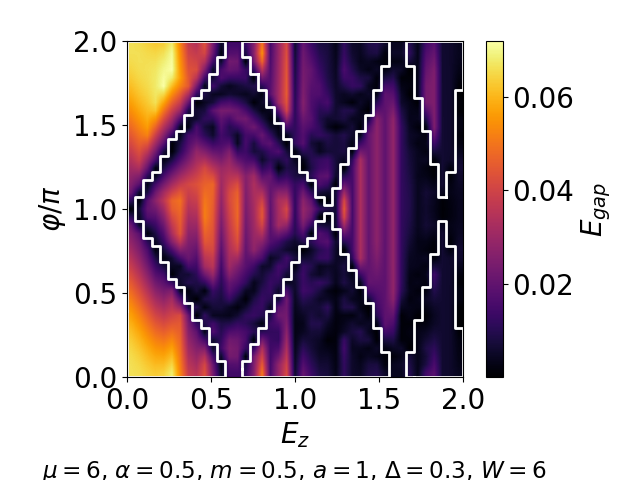

In [233]:
import matplotlib as mpl

mpl.rcParams.update({'font.size': 20})

# E_th:
E_T = 0.5*np.pi*np.sqrt(2*params.mu / params.m_eff)/params.W

fig , ax = plt.subplots()
Z , Phi = np.meshgrid(zee_values , phase_values)

im = ax.imshow(E_gap , extent= [np.min(zee_values) , np.max(zee_values) , np.min(phase_values) , np.max(phase_values)] , cmap = 'inferno' , interpolation= 'bilinear')
ax.set_xlabel(r'$E_{z}$')
ax.set_ylabel(r'$\varphi / \pi$')


# parameter string:
title = r'$\mu = $' + str(params.mu) + ', ' + r'$\alpha = $' + str(params.alpha) + ', ' +  r'$m = $' + str(params.m_eff) + r', $a = $' + str(params.a) + r', $\Delta = $' + str(params.Deltabottom) + r', $W = $' + str(params.W)
fig.text(0.46 , 0.005 , title , ha = 'center' , fontsize = 'small')
plt.colorbar(mappable = im , label = r'$E_{gap}$')

import shapely.geometry
import shapely.ops

geoms = []

ph = np.linspace(0 , np.max(phase_values) , len(phase_values) + 1)
zee = np.linspace(0 , np.max(zee_values) , len(zee_values) + 1)

for yidx, xidx in zip(*np.where(np.array(0.5*(chern_numbers + 1) , dtype = 'int'))):
    geoms.append(shapely.geometry.box(ph[xidx], zee[yidx], ph[xidx+1], zee[yidx+1]))
full_geom = shapely.ops.unary_union(geoms)

for geom in full_geom.geoms:
    plt.plot(*geom.exterior.xy, linewidth=2, color='w')


# ax.axvline(E_T , color = 'r')
plt.tight_layout()

Run this cell if you want to save the current notebook to the `savedsessions` folder

In [232]:
# import dill
# # Dill save session string:
# from datetime import datetime
# when = datetime.today().strftime('%d-%m-%Y-%H-%M-%S')

# import os

# cwd = os.getcwd()
# filepath = str(cwd) + '/savedsessions/'
# savestring = filepath + 'BandStructsGap' + when + '.nb'
# dill.dump_session(savestring)

